# Using MLServe.com with causal ml models

MLServe.com also supports deployment of causal models. The developer isn't required to use any ml specific libraries for estimation (e.g. econml, causalml etc). Instead you just build a standard ML model (eg. xgboost) with your covariates and actions / interventions

$$\hat y = f(X, A)$$

MLServe.com takes your estimated model and calculates treatment effects and next best action internally. Then upon inference you only provide the input features and get back the best action

## Problem Formation, Identification and Estimation

We developed a causal machine learning model simulating an online marketing scenario, where ad exposure acts as the treatment and purchase as the outcome. The data include realistic confounders—income, age, and user_interest—that influence both exposure and purchase behavior. A synthetic dataset is generated with heterogeneous treatment effects, ensuring that advertising benefits vary across users (e.g., uninterested users show no lift).
The causal graph identifies a valid backdoor adjustment set of {income, age, user_interest}, ensuring unbiased estimation of the treatment’s effect on purchase.
An XGBoost classifier trained on these adjusted variables predicts individual purchase probabilities. 

This setup demonstrates how causal structure and predictive modeling can be combined to infer the true impact of digital advertising interventions while accounting for confounding effects.

In [1]:
import collections, collections.abc
collections.Iterable = collections.abc.Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

from mlserve_sdk.client import MLServeClient
import os
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
def generate_marketing_causal_data(
    n_samples=2000,
    treatment_effect_mean=0.5,
    treatment_effect_std=0.3,
    confounding_strength=0.6,
    noise_std=0.5,
    seed=None
):
    """
    Generate realistic synthetic data for an online marketing causal setup.
    Ad exposure is the treatment, purchase is the outcome.
    Confounders: income, user_interest (affect both treatment & outcome).
    """

    if seed is not None:
        np.random.seed(seed)

    # --- Confounders ---
    age = np.random.normal(35, 10, n_samples)
    income = np.clip(2000 + 150 * age + np.random.normal(0, 3000, n_samples), 1000, 15000)
    user_interest = np.random.beta(2, 2, n_samples)  # 0–1 scale

    # --- Treatment assignment (ad exposure) ---
    logits = (
        -2
        + 0.3 * (income / 10000)
        + 1.5 * user_interest
        + confounding_strength * np.random.normal(0, 1, n_samples)
    )
    prob_treatment = 1 / (1 + np.exp(-logits))
    ad_exposure = np.random.binomial(1, prob_treatment)

    # --- Individual treatment effects ---
    tau = np.random.normal(treatment_effect_mean, treatment_effect_std, size=n_samples)
    tau[user_interest < 0.2] = 0  # uninterested users get no lift from ads

    # --- Baseline purchase probability ---
    baseline = (
        -3
        + 0.0002 * income
        + 2.0 * user_interest
        + np.random.normal(0, noise_std, n_samples)
    )
    prob_purchase = 1 / (1 + np.exp(-(baseline + ad_exposure * tau)))
    purchase = np.random.binomial(1, prob_purchase)

    # --- Build DataFrame ---
    df = pd.DataFrame({
        "age": age,
        "income": income,
        "user_interest": user_interest,
        "ad_exposure": np.where(ad_exposure == 1, "variant", "control"),
        "purchase": purchase,
    })
    df["ad_exposure"] = df["ad_exposure"].astype("category")

    return df

         age       income  user_interest ad_exposure  purchase
0  39.967142  5969.536405       0.324647     variant         0
1  33.617357  6609.047536       0.150209     control         0
2  41.476885  5844.273044       0.297625     control         0
3  50.230299  8610.660196       0.262993     variant         1
4  32.658466  1217.925937       0.604444     control         0




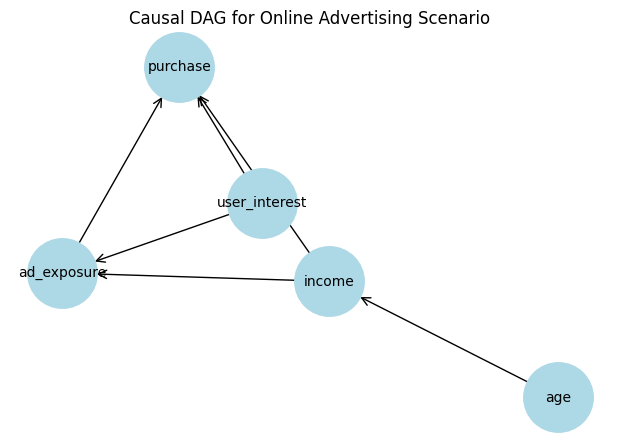


Backdoor adjustment sets:
   frozenset({'income', 'user_interest'})
   frozenset({'age', 'income', 'user_interest'})


In [2]:
# === Generate data ===
df = generate_marketing_causal_data(seed=42)
print(df.head())
print('\n')

# === Define and visualize causal graph ===
cg = CausalGraphicalModel(
    nodes=["age", "income", "user_interest", "ad_exposure", "purchase"],
    edges=[
        ("age", "income"),
        ("income", "ad_exposure"),
        ("income", "purchase"),
        ("user_interest", "ad_exposure"),
        ("user_interest", "purchase"),
        ("ad_exposure", "purchase"),
    ],
)

# --- Plot the DAG ---
try:
    edges = list(cg.graph.edges)
except AttributeError:
    edges = list(cg.edges)

G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42, k=0.5)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2500,
    node_color="lightblue",
    font_size=10,
    arrows=True,
    arrowstyle="->",
    arrowsize=15,
)
plt.title("Causal DAG for Online Advertising Scenario")
plt.show()

# === Identify valid adjustment sets ===
backdoor_sets = cg.get_all_backdoor_adjustment_sets("ad_exposure", "purchase")
print("\nBackdoor adjustment sets:")
for s in backdoor_sets:
    print("  ", s)


## Model Training

In [7]:
# preparing for mlserve:
# rename ad exposure to treatment as this is how mlserve.com expect the intervention column. 
# In addition, the control group should be named as control.
df=df.rename(columns={"ad_exposure":"treatment"})

# Backdoor adjustment
X = df[["income", "age", "user_interest", "treatment"]]
y = df["purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = XGBClassifier(
    enable_categorical=True,
    n_estimators=300,
    max_depth=6)

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print(f"✅ XGBoost AUC: {auc:.3f}")

✅ XGBoost AUC: 0.621


## Model Deployment

In [8]:
USERNAME = os.getenv("USERNAME")
TOKEN = os.getenv("TOKEN")

client = MLServeClient()
client.login(USERNAME, TOKEN)

In [9]:
try:
    lv=client.get_latest_version("ad_exposure")
    next_version=lv["next_version"]
except:
    next_version="v1"

print(next_version)

v1


In [10]:
cols=list(X_test)
client.deploy(
    model=model,
    name="ad_exposure",
    version="v1",
    features=cols,
    background_df=X_test.head(500),
    task_type='next_best_action', # IMPORTANT: task_type should be next_best_action for optimal treatment prediction
    metrics={'auc':auc}
)

{'predict_url': 'https://mlserve.com/api/v1/predict/ad_exposure/v1'}

## Recommendations

MLServe.com converts predictions into treatment effects and scans through all available treatments to give you back the treatment that maximises your target variable (e.g. purchase)

In [11]:
%%time

TEST_DATA = {
    "features": list(X_test.drop('treatment', axis=1)),
    "inputs": X_test.reset_index(drop=True).drop('treatment', axis=1).values.tolist()[:10]
}
preds = client.predict("ad_exposure", "v1", TEST_DATA, explain=True)
print("Predictions:", preds)

Predictions: {'version': 'v1', 'prediction_ids': ['4573f0e9-6016-4e3e-851b-fa2ade731d79', 'f99cc35d-ab1b-4f38-b7a2-a709a0d87012', '0a386f56-9e30-4702-b1f9-a9605890610d', 'ed885ca5-15eb-4821-a399-fd9e999fcdcd', 'c013bff1-e6ae-4e95-b714-172192484dc6', 'eb515b7d-2e3b-4b0f-952d-75694cb66e35', '315f6741-4299-4eb5-a09f-e03cdb390071', '57617cc6-3099-49ac-bf2a-366508aed39d', 'f5e5c2b6-fabb-4d76-9de9-b74a871dc757', '63b975dc-93d5-44d3-bdc9-62c9d1e0d9a7'], 'predictions': [['control', 0, 0], ['control', 0, 0], ['control', 0, 0], ['control', 0, 0], ['variant', 0, 1], ['control', 0, 0], ['control', 0, 0], ['variant', 0, 1], ['control', 0, 0], ['control', 0, 0]], 'explanations': [[{'feature': 'user_interest', 'value': 0.37, 'shap_value': -1.208, 'impact': 'negative'}, {'feature': 'income', 'value': 5692.69, 'shap_value': -0.985, 'impact': 'negative'}, {'feature': 'treatment', 'value': 'control', 'shap_value': -0.485, 'impact': 'negative'}], [{'feature': 'income', 'value': 2912.23, 'shap_value': -3.3